In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
import torch
from pathlib import Path

In [5]:
# 1. load the COCO-pretrained YOLOv5s
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in /Users/seijimatsuda/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-5-22 Python-3.10.17 torch-2.6.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


## Important: This is needed after loading yolo v5
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

under the hood it pulls in a bunch of native libs (OpenCV, threading hooks, etc.) that can inadvertently switch off the Jupyter “inline” display backend. The fix is simply to re-enable the inline backend (or interactive mode) after you load the model. For example:

```
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
plt.ion()
```

In [6]:
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
plt.ion()

In [7]:
soccer_path = Path('../pressure')
soccer_images = list(soccer_path.glob('*.png'))
imgs = [path.as_posix() for path in soccer_images]

In [8]:
# 2. inference
results = model(imgs)   # replace with your files

ValueError: zero-size array to reduction operation maximum which has no identity

In [6]:
# 3. render to get annotated BGR arrays
rendered = results.render()

NameError: name 'results' is not defined

In [7]:
plt.imshow(rendered[0])

NameError: name 'rendered' is not defined

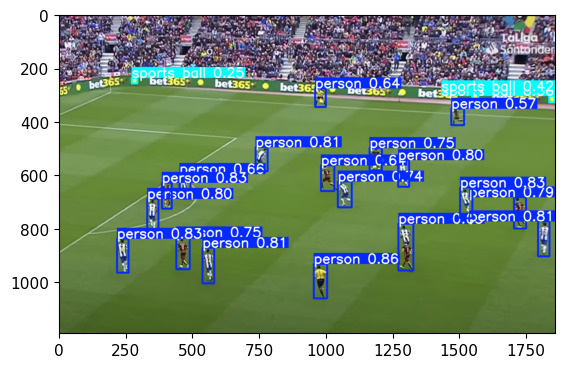

In [14]:
plt.imshow(rendered[1])

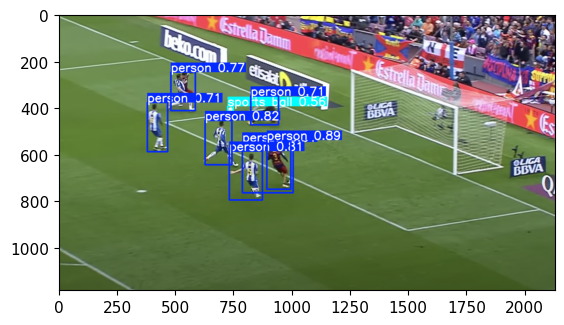

In [15]:
plt.imshow(rendered[2])

In [9]:
# Complete Pipeline: YOLOv5 Detection -> Save Results -> ResNet Processing

import os
import json
import csv
from pathlib import Path
import torch
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import numpy as np

# ===== STEP 1: CREATE OUTPUT DIRECTORIES =====
def create_output_directories():
    """Create necessary output directories"""
    directories = [
        "output/annotated_images",
        "output/cropped_detections", 
        "output/detection_data",
        "output/resnet_features"
    ]
    
    for directory in directories:
        Path(directory).mkdir(parents=True, exist_ok=True)
    
    print("✅ Created output directories:")
    for directory in directories:
        print(f"  - {directory}")

# ===== STEP 2: EXTRACT AND SAVE YOLO RESULTS =====
def extract_and_save_yolo_results(results, imgs, output_base="output"):
    """
    Extract all detection data from YOLOv5 results and save everything
    
    Returns:
    - detection_data: List of dictionaries with all detection info
    - saved_files: Dictionary of saved file paths
    """
    detection_data = []
    saved_files = {
        'annotated_images': [],
        'cropped_detections': [],
        'detection_csvs': []
    }
    
    # Process each image result
    for img_idx, (result, img_path) in enumerate(zip(results.xyxy, imgs)):
        img_name = Path(img_path).stem
        
        # 1. SAVE ANNOTATED IMAGE
        rendered_img = results.render()[img_idx]
        annotated_path = f"{output_base}/annotated_images/{img_name}_annotated.png"
        Image.fromarray(rendered_img).save(annotated_path)
        saved_files['annotated_images'].append(annotated_path)
        
        # 2. LOAD ORIGINAL IMAGE FOR CROPPING
        original_img = Image.open(img_path)
        
        # 3. EXTRACT DETECTION DATA
        detections = result.cpu().numpy()  # Convert to numpy
        img_detections = []
        
        for det_idx, detection in enumerate(detections):
            x1, y1, x2, y2, confidence, class_id = detection
            
            # Create detection record
            detection_record = {
                'image_path': img_path,
                'image_name': img_name,
                'detection_id': det_idx,
                'x1': float(x1),
                'y1': float(y1), 
                'x2': float(x2),
                'y2': float(y2),
                'width': float(x2 - x1),
                'height': float(y2 - y1),
                'confidence': float(confidence),
                'class_id': int(class_id),
                'class_name': results.names[int(class_id)]
            }
            
            # 4. CROP AND SAVE DETECTION
            cropped_img = original_img.crop((x1, y1, x2, y2))
            crop_filename = f"{img_name}_det_{det_idx}_{detection_record['class_name']}_{confidence:.2f}.png"
            crop_path = f"{output_base}/cropped_detections/{crop_filename}"
            cropped_img.save(crop_path)
            
            detection_record['cropped_image_path'] = crop_path
            img_detections.append(detection_record)
            saved_files['cropped_detections'].append(crop_path)
        
        detection_data.extend(img_detections)
        
        # 5. SAVE DETECTION DATA AS CSV (per image)
        if img_detections:
            csv_path = f"{output_base}/detection_data/{img_name}_detections.csv"
            pd.DataFrame(img_detections).to_csv(csv_path, index=False)
            saved_files['detection_csvs'].append(csv_path)
    
    # 6. SAVE COMBINED DETECTION DATA
    if detection_data:
        # Save as CSV
        combined_csv = f"{output_base}/detection_data/all_detections.csv"
        pd.DataFrame(detection_data).to_csv(combined_csv, index=False)
        
        # Save as JSON
        combined_json = f"{output_base}/detection_data/all_detections.json"
        with open(combined_json, 'w') as f:
            json.dump(detection_data, f, indent=2)
        
        print(f"✅ Saved {len(detection_data)} detections from {len(imgs)} images")
        print(f"📁 Annotated images: {len(saved_files['annotated_images'])}")
        print(f"✂️ Cropped detections: {len(saved_files['cropped_detections'])}")
        print(f"📊 Detection data: {combined_csv}")
    
    return detection_data, saved_files

# ===== STEP 3: RESNET MODEL SETUP =====
def setup_resnet_model(model_name='resnet50', pretrained=True):
    """
    Setup ResNet model for feature extraction
    
    Available models: resnet18, resnet34, resnet50, resnet101, resnet152
    """
    import torchvision.models as models
    
    # Load pretrained ResNet
    if model_name == 'resnet18':
        model = models.resnet18(pretrained=pretrained)
    elif model_name == 'resnet34':
        model = models.resnet34(pretrained=pretrained)
    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=pretrained)
    elif model_name == 'resnet101':
        model = models.resnet101(pretrained=pretrained)
    elif model_name == 'resnet152':
        model = models.resnet152(pretrained=pretrained)
    else:
        raise ValueError(f"Unknown model: {model_name}")
    
    # Remove the final classification layer to get features
    model = torch.nn.Sequential(*list(model.children())[:-1])
    model.eval()
    
    # Define image preprocessing
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225]),
    ])
    
    print(f"✅ Setup {model_name} model for feature extraction")
    return model, preprocess

# ===== STEP 4: PROCESS DETECTIONS THROUGH RESNET =====
def process_detections_with_resnet(detection_data, resnet_model, preprocess, output_base="output"):
    """
    Process all cropped detections through ResNet and save features
    """
    features_data = []
    
    print(f"🔄 Processing {len(detection_data)} detections through ResNet...")
    
    with torch.no_grad():
        for i, detection in enumerate(detection_data):
            try:
                # Load cropped image
                img_path = detection['cropped_image_path']
                image = Image.open(img_path).convert('RGB')
                
                # Preprocess image
                input_tensor = preprocess(image).unsqueeze(0)
                
                # Extract features
                features = resnet_model(input_tensor)
                features = features.squeeze().numpy()
                
                # Create feature record
                feature_record = {
                    'detection_id': detection['detection_id'],
                    'image_name': detection['image_name'],
                    'class_name': detection['class_name'],
                    'confidence': detection['confidence'],
                    'cropped_image_path': img_path,
                    'feature_vector': features.tolist(),  # Convert to list for JSON
                    'feature_shape': features.shape,
                    'feature_mean': float(features.mean()),
                    'feature_std': float(features.std())
                }
                
                features_data.append(feature_record)
                
                if (i + 1) % 10 == 0:
                    print(f"  Processed {i + 1}/{len(detection_data)} detections...")
                    
            except Exception as e:
                print(f"  ❌ Error processing {detection.get('cropped_image_path', 'unknown')}: {e}")
    
    # Save features data
    if features_data:
        # Save detailed features as JSON
        features_json = f"{output_base}/resnet_features/resnet_features.json"
        with open(features_json, 'w') as f:
            json.dump(features_data, f, indent=2)
        
        # Save summary as CSV (without feature vectors)
        summary_data = []
        for feature in features_data:
            summary = {k: v for k, v in feature.items() if k != 'feature_vector'}
            summary_data.append(summary)
        
        summary_csv = f"{output_base}/resnet_features/resnet_features_summary.csv"
        pd.DataFrame(summary_data).to_csv(summary_csv, index=False)
        
        # Save just the feature vectors as numpy array
        feature_vectors = np.array([f['feature_vector'] for f in features_data])
        features_npy = f"{output_base}/resnet_features/feature_vectors.npy"
        np.save(features_npy, feature_vectors)
        
        print(f"✅ Saved ResNet features for {len(features_data)} detections")
        print(f"📊 Features JSON: {features_json}")
        print(f"📊 Summary CSV: {summary_csv}")
        print(f"🔢 Feature vectors: {features_npy} (shape: {feature_vectors.shape})")
    
    return features_data

# ===== STEP 5: MAIN PIPELINE FUNCTION =====
def run_complete_pipeline(results, imgs, resnet_model_name='resnet50'):
    """
    Run the complete pipeline: YOLOv5 -> Save Results -> ResNet processing
    """
    print("🚀 Starting complete YOLOv5 to ResNet pipeline...")
    
    # Step 1: Create directories
    create_output_directories()
    
    # Step 2: Extract and save YOLO results
    detection_data, saved_files = extract_and_save_yolo_results(results, imgs)
    
    if not detection_data:
        print("❌ No detections found. Pipeline stopped.")
        return None, None, None
    
    # Step 3: Setup ResNet model
    resnet_model, preprocess = setup_resnet_model(resnet_model_name)
    
    # Step 4: Process through ResNet
    features_data = process_detections_with_resnet(detection_data, resnet_model, preprocess)
    
    print("🎉 Pipeline completed successfully!")
    
    return detection_data, features_data, saved_files

# ===== USAGE EXAMPLE =====
"""
# After you have your YOLOv5 results, run this:

# Run the complete pipeline
detection_data, features_data, saved_files = run_complete_pipeline(results, imgs, 'resnet50')

# Or run steps individually:
create_output_directories()
detection_data, saved_files = extract_and_save_yolo_results(results, imgs)
resnet_model, preprocess = setup_resnet_model('resnet50')
features_data = process_detections_with_resnet(detection_data, resnet_model, preprocess)
"""

"\n# After you have your YOLOv5 results, run this:\n\n# Run the complete pipeline\ndetection_data, features_data, saved_files = run_complete_pipeline(results, imgs, 'resnet50')\n\n# Or run steps individually:\ncreate_output_directories()\ndetection_data, saved_files = extract_and_save_yolo_results(results, imgs)\nresnet_model, preprocess = setup_resnet_model('resnet50')\nfeatures_data = process_detections_with_resnet(detection_data, resnet_model, preprocess)\n"